# U-Net binary-segmentation training

This program loads the Galaxy Zoo 3D dataset (previously downloaded) and trains a U-Net model that predicts binary-segmentation masks for each galaxy.

The last and the best models are save in a .h5 format alongside a .csv file with the evolution of all metrics for each epoch.

In addition, some examples of masks predicted by the trained model are shown in the last section and compared with its true mask.

# Complete

In [ ]:
run_from = 'google_colab'   # Options are 'google_colab', 'amazon_sagemaker' or 'local'.
                            # This notebook asumes that the dataset is in the /root/tensorflow_datasets
                            # directory of each enviroment and that it is named 'galaxy_zoo3d'. If
                            # 'google_colab' is selected, you will have to specified the path where the
                            # dataset is stored in your drive in the "Libraries" section in order to copy
                            # it in the /root directory. YOU WILL ALSO HAVE TO CHANGE THE SAVING PATHS IN
                            # THE "Callbacks" SECTION ACCORDINGLY.

NUM_EPOCHS = 150            # Number of epochs the model is trained for.

size = 128                  # Size of the images and masks that are resized in the pipeline (in pixels).
                            # Original size is 525x525. If you change this parameter, you will probably
                            # have to change batch sizes as well in the "Data loader" section.
                            # This notebook works only with sizes that are a power of 2.

mask = 'spiral_mask'        # Options are 'spiral_mask' or 'bar_mask'. Weather you want to train a model
                            # that predicts spiral arms or bars for each galaxy. This selects the
                            # respective masks from the dataset.

train_with = 'all'          # Options are 'only' or 'all'. Weather you want to train your model with
                            # images that "only" have spiral arms (bars) or you want to train it with
                            # "all" the images in the training dataset.

min_vote = 3                # If 'only' is selected, this parameter defines the minimum amount of votes
                            # that the most voted pixel of a mask must have in order to be considered a
                            # spiral arm (barred) galaxy.

threshold = 6               # To construct binary masks it is necessary to specify a threshold.
                            # This parameter defines the minimum amount of votes that a pixel
                            # must have in order to be clasified as a spiral arm (bar). A pixel with
                            # this amount of votes or more is assigned a value of 1 and a pixel with
                            # less amount of votes is assigned a value of 0.

patience = 10               # You can choose to stop training after 'patience' amount of epochs
                            # without improvement in the validation loss. You can also choose to monitor
                            # other metrics in the "Callbacks" section.

# Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
from datetime import datetime
from sklearn.metrics import confusion_matrix, jaccard_score
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.models import load_model



if run_from == 'google_colab':

    from google.colab import drive

    drive.mount('/content/drive')
    !mkdir /root/tensorflow_datasets
    !cp -r /content/drive/MyDrive/galaxy-segmentation-project/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/.


elif run_from == 'amazon_sagemaker':

    import matplotlib as mpl

    mpl.rcParams['xtick.color'] = 'w'
    mpl.rcParams['ytick.color'] = 'w'
    mpl.rcParams['xtick.labelcolor'] = 'w'
    mpl.rcParams['axes.labelcolor'] = 'w'
    mpl.rcParams['axes.titlecolor'] = 'w'

Mounted at /content/drive


# Data

## Useful functions

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")

    return input_image, input_mask


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    return input_image, input_mask


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image


def binary_mask(input_mask):
    th = threshold
    input_mask = tf.where(input_mask<th, tf.zeros_like(input_mask), tf.ones_like(input_mask))

    return input_mask


def load_image_train(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Image', 'Mask', 'Prediction']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.title(titles[i])
    plt.axis("off")
  plt.show()

## Data loader

In [ ]:
ds, info = tfds.load('galaxy_zoo3d', split=['train[:75%]', 'train[75%:]'], with_info=True)
ds_train, ds_test = ds[0], ds[1]

if train_with == 'all':
  BUFFER_SIZE, BATCH_SIZE = 1000, 64
  TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 22360, 4992, 2461
elif train_with == 'only':
  BUFFER_SIZE, BATCH_SIZE = 300, 32
  if mask == 'spiral_mask':
    ds_train = ds_train.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)
    TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 4883, 1088, 551
  elif mask == 'bar_mask':
    ds_train = ds_train.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)
    TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 3783, 832, 421

In [ ]:
train_dataset = ds_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = ds_test.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(VAL_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.skip(VAL_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)

# U-Net

## Model

In [ ]:
def double_conv_block(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x


def downsample_block(x, n_filters):

    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p


def upsample_block(x, conv_features, n_filters):

    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
def build_unet_model():

    inputs = layers.Input(shape=(size,size,3))

    f1, p1 = downsample_block(inputs, size/2)
    f2, p2 = downsample_block(p1, size)
    f3, p3 = downsample_block(p2, size*2)
    f4, p4 = downsample_block(p3, size*4)

    bottleneck = double_conv_block(p4, size*8)

    u6 = upsample_block(bottleneck, f4, size*4)
    u7 = upsample_block(u6, f3, size*2)
    u8 = upsample_block(u7, f2, size)
    u9 = upsample_block(u8, f1, size/2)

    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

## Callbacks

In [ ]:
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
filename = f'{date}_{train_with}_'+mask.split('_')[0]+'-'+mask.split('_')[1]+f'_epochs:{NUM_EPOCHS}_size:{size}_th:{threshold}_patience:{patience}'
if run_from == 'google_colab':
  path = '/content/drive/MyDrive/galaxy-segmentation-project/Modelos/'
elif run_from == 'amazon_sagemaker':
  path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/galaxy-segmentation-project/Modelos/'
elif run_from == 'local':
  path = '/home/samu/Desktop/Tesis/Modelos'
# os.mkdir(f'{path}{filename}')

filename = '2023_05_13-17:59:49_all_spiral-mask_epochs:150_size:128_th:6_patience:10'

csv_log = CSVLogger(f'{path}{filename}/{filename}.csv', append=True)
early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
mcp_save_best = ModelCheckpoint(filepath=f'{path}{filename}/{filename}_best.h5', monitor='val_accuracy', mode='max', save_best_only=True)
mcp_save_last = ModelCheckpoint(filepath=f'{path}{filename}/{filename}_last.h5')

## Training

In [ ]:
unet_model = build_unet_model()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy"
                  )

# unet_model = load_model(f'{path}{filename}/{filename}_last.h5')

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENGTH = VAL_SIZE + TEST_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

start = time.time()
model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                               callbacks=[csv_log, early_stop, mcp_save_best, mcp_save_last])

In [ ]:
# !pip install visualkeras

import visualkeras as vk
from PIL import ImageFont
from urllib.request import urlopen

font = ImageFont.truetype('/content/drive/MyDrive/galaxy-segmentation-project/temp/arbutusslab-regular.ttf', size=41)

vk.layered_view(unet_model, legend=True, font=font)
unet_model.summary()

### Time

In [ ]:
end = time.time()
segs = end-start
hours =  int(segs/3600)
minutes = (segs-hours*3600)/60
print(f'It took {hours}hs {round(minutes)}min to train this model')
# Hasta época 11, 4727 seg.

It took 2hs 8min to train this model


# Learning curves

## Display functions

In [ ]:
def display_learning_curves(history):

    val_acc = history.history["val_accuracy"]
    acc = history.history["accuracy"]

    val_loss = history.history["val_loss"]
    loss = history.history["loss"]

    epochs_range = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].plot(epochs_range, loss, label="train loss", linewidth=2.5)
    ax[0].plot(epochs_range, val_loss, label="validation loss", linewidth=2.5)
    ax[0].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[0].set_ylabel("Loss", fontsize=20, labelpad=10)
    ax[0].set_ylim(min(min(loss), min(val_loss)), max(max(loss[1:]), max(val_loss[1:])))
    ax[0].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc="best", fontsize=15)

    ax[1].plot(epochs_range, acc, label="train accuracy", linewidth=2.5)
    ax[1].plot(epochs_range, val_acc, label="validation accuracy", linewidth=2.5)
    ax[1].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[1].set_ylabel("Accuracy", fontsize=20, labelpad=10)
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].legend(loc="best", fontsize=15)

    fig.tight_layout()
    fig.show()

## Learning graphs

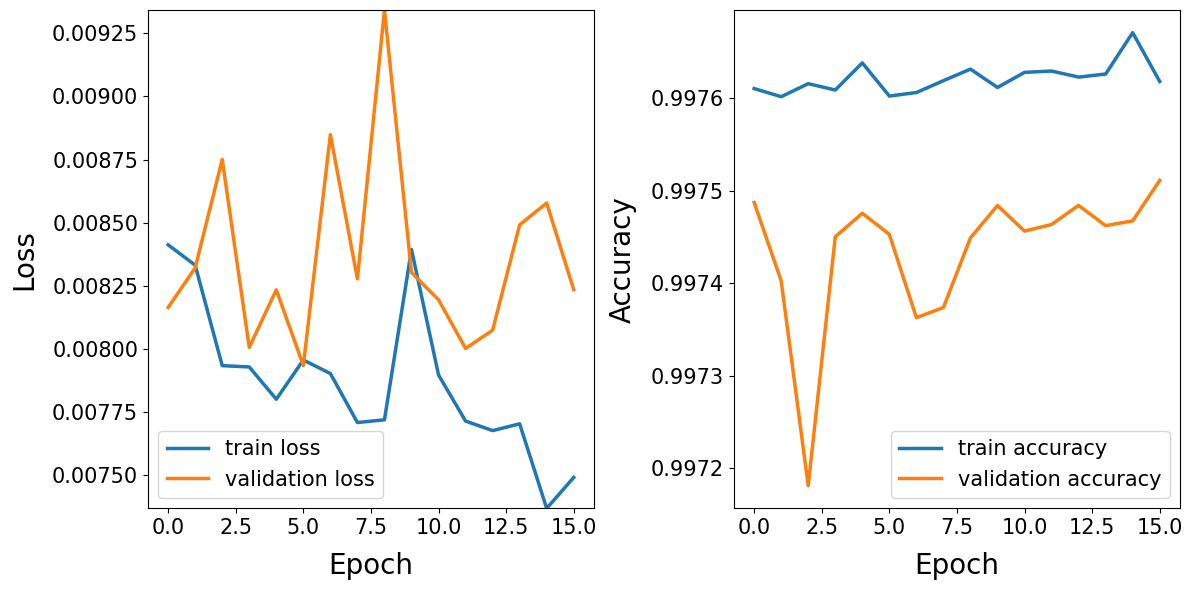

In [ ]:
display_learning_curves(unet_model.history)

# Predictions

## Prediction funcitons

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset:
      pred_mask = create_mask(unet_model.predict(image))
      for ind in range(num):
        display([image[ind], mask[ind], pred_mask[ind]])
        if np.amax(pred_mask[ind].numpy()) == 0:
          print(2*'\n')
          continue
        else:
          conf_matrix = confusion_matrix(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          jacc_score = jaccard_score(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          print('Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: \n',
          conf_matrix, '\t',
          round(conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]), 2), 2*'\t  ',
          round(conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1]), 2), '\t     ',
          round(conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]), 2), 2*'\t',
          round(jacc_score, 2), '\n')

## Prediction examples

2/2 [==============================] - 5s 11ms/step


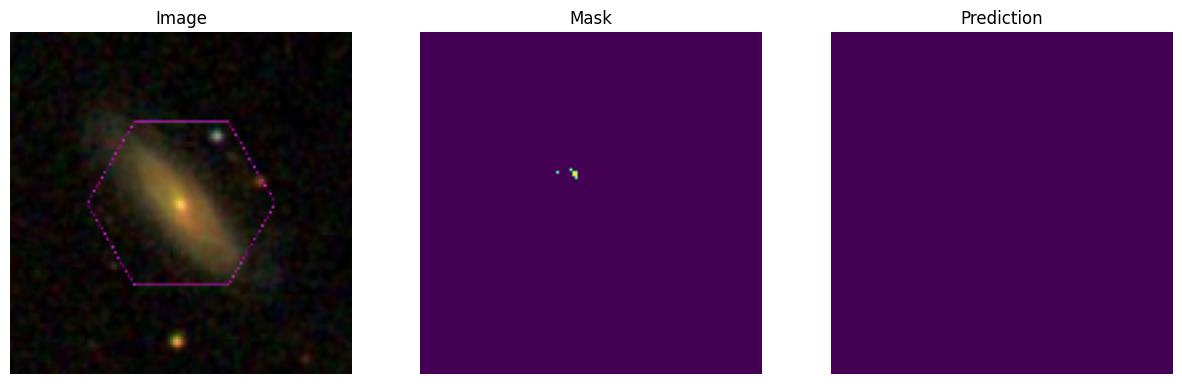

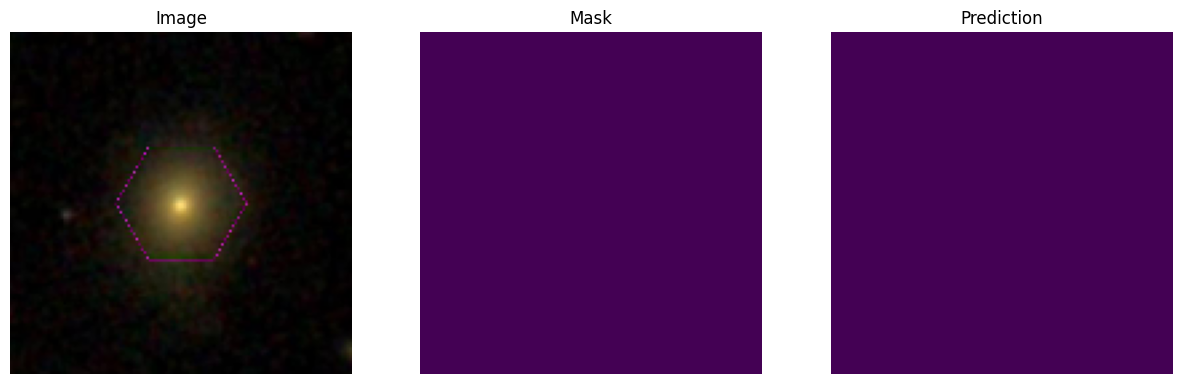

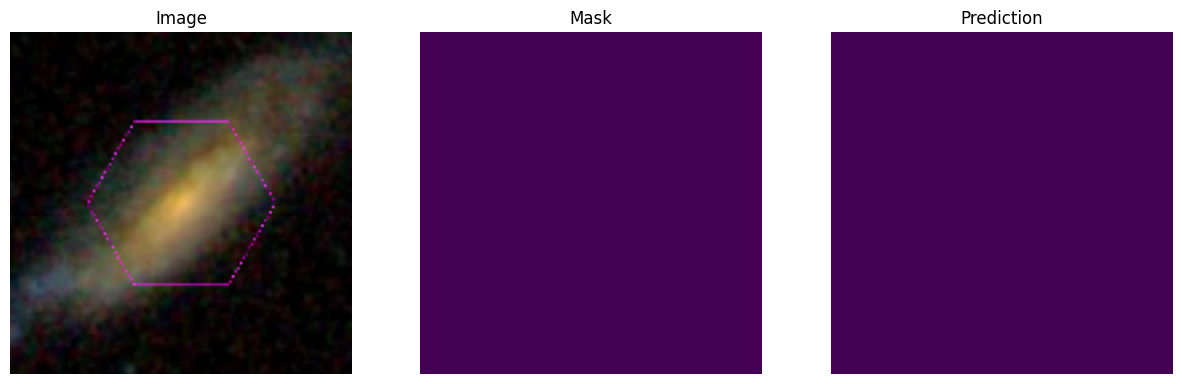

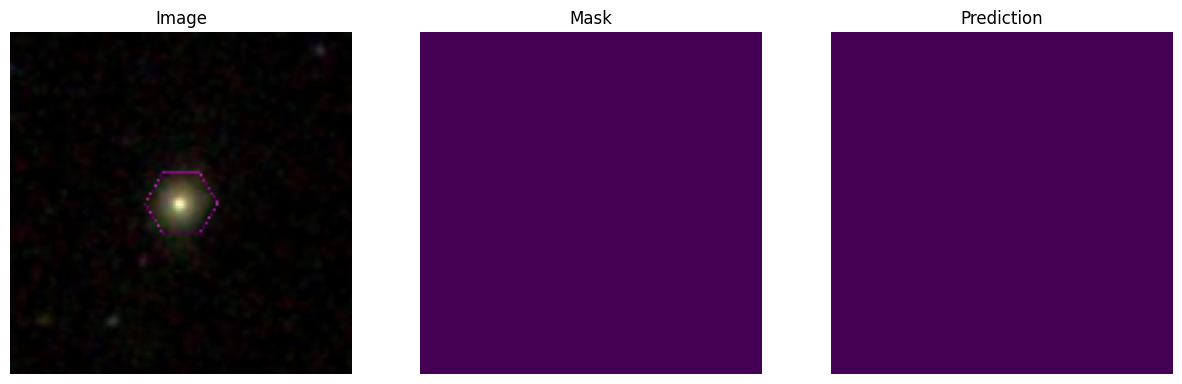

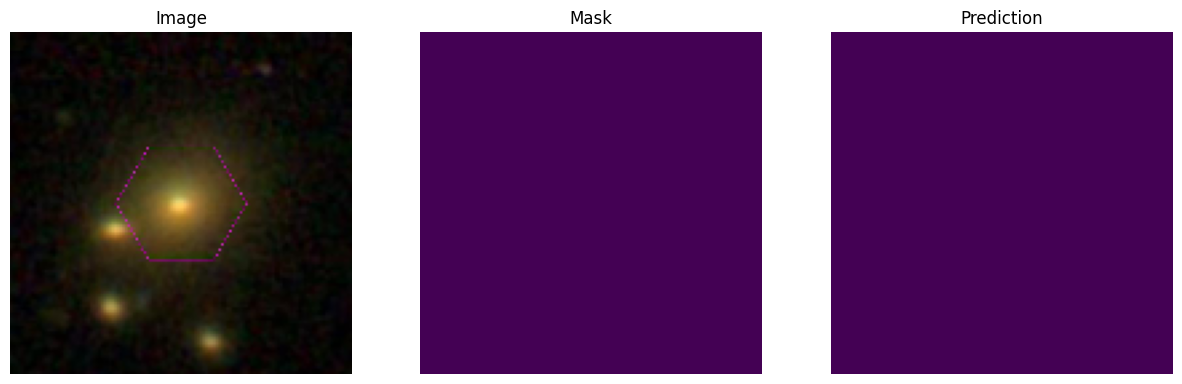

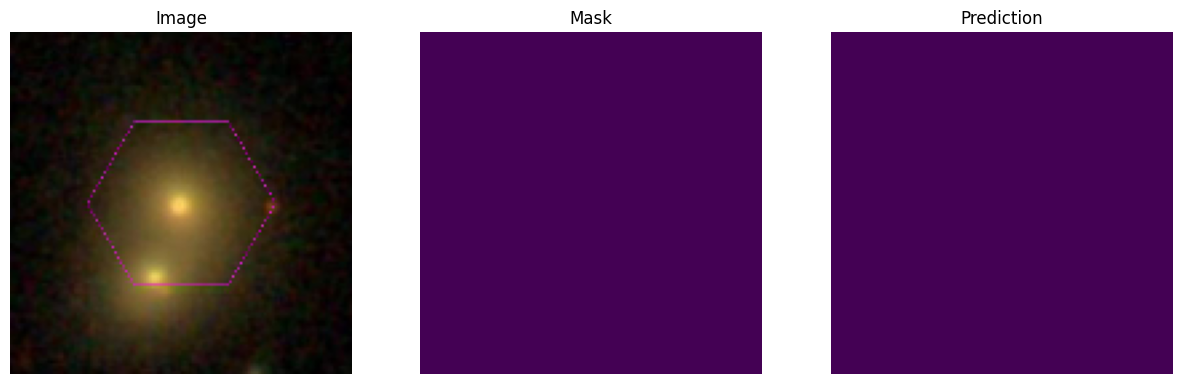

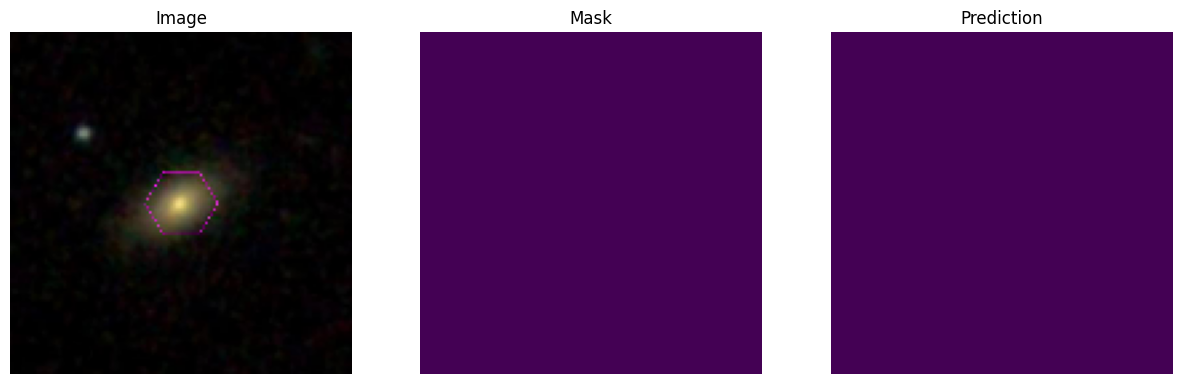

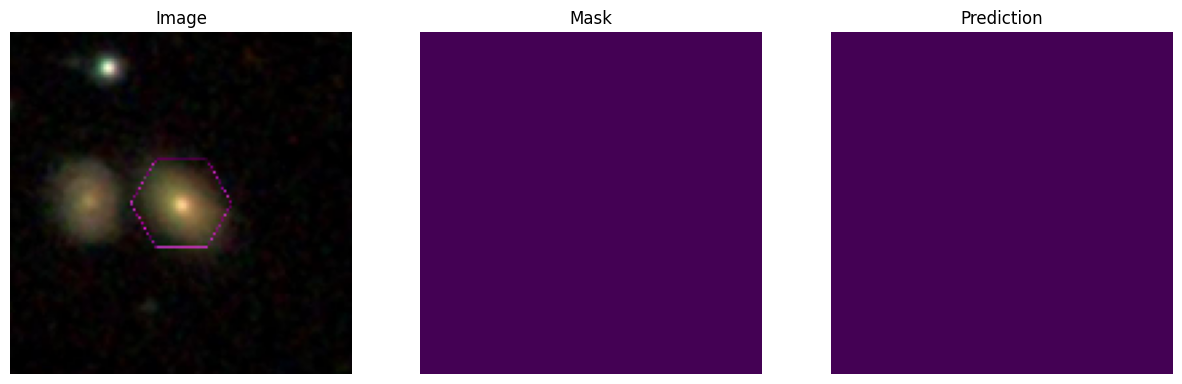

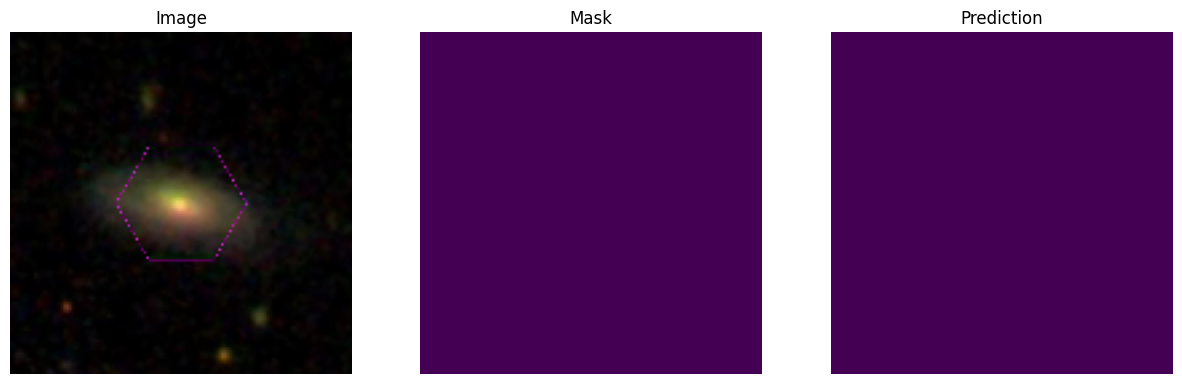

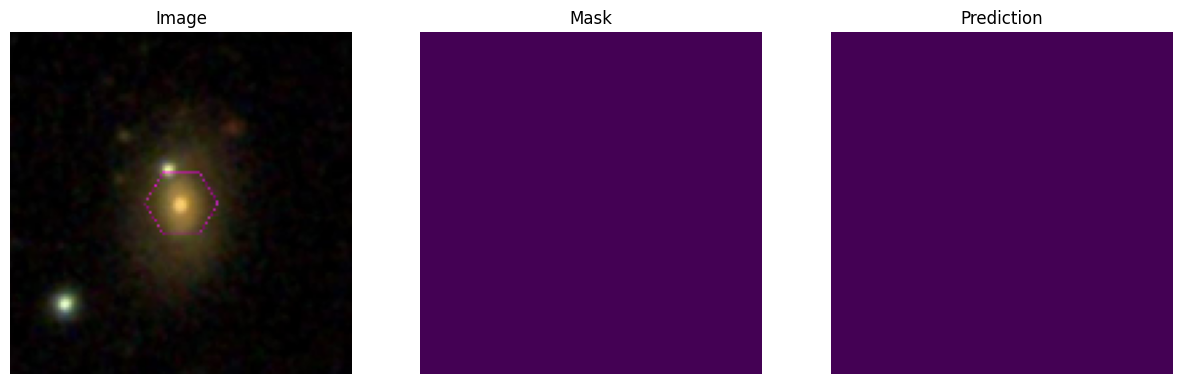

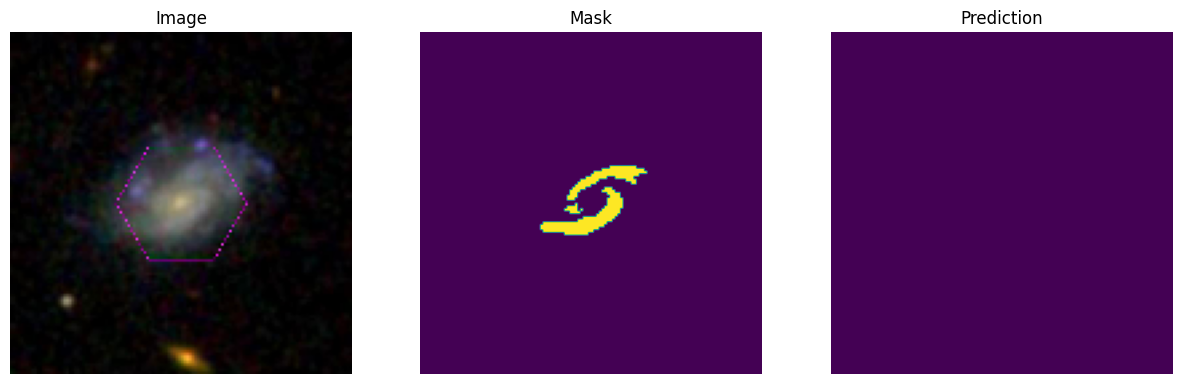

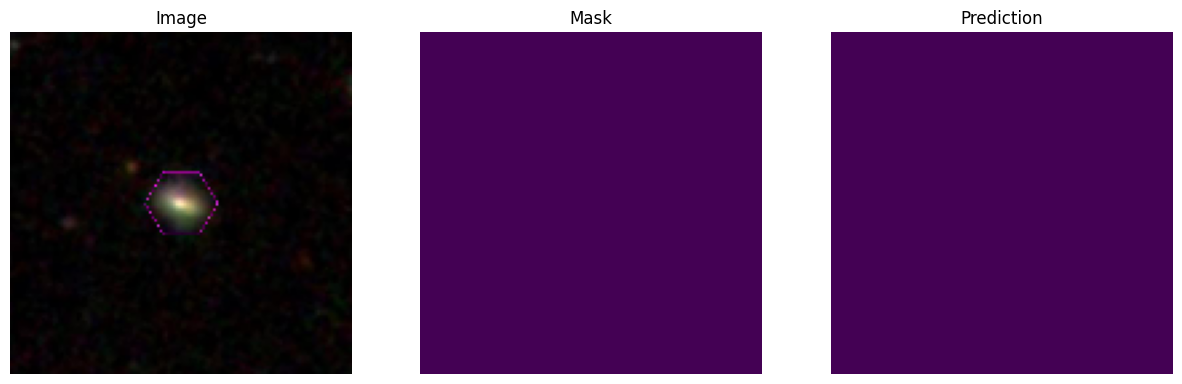

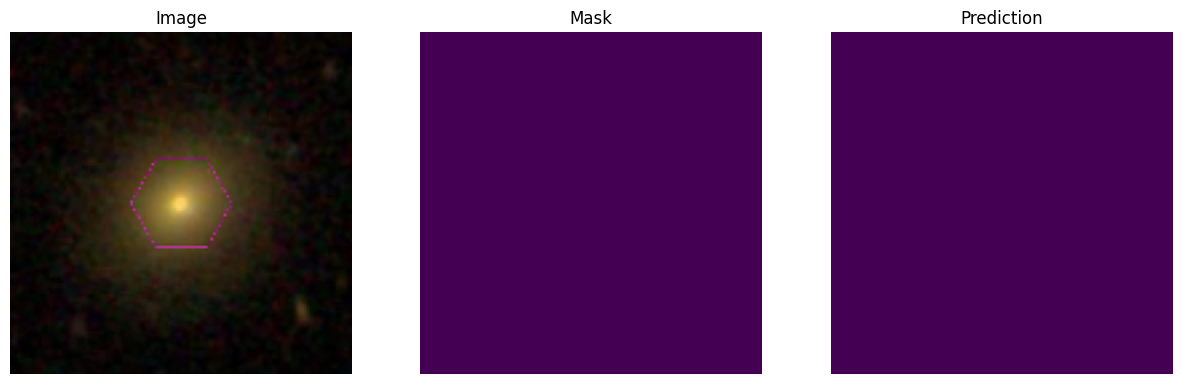

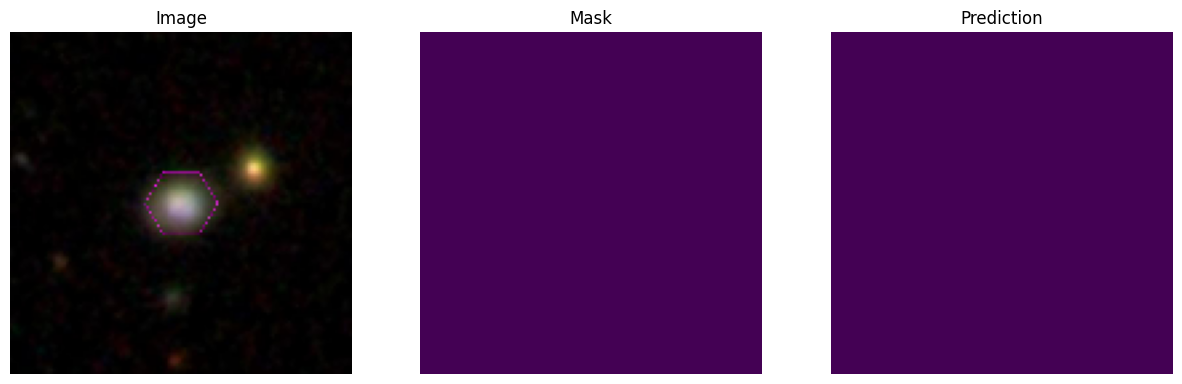

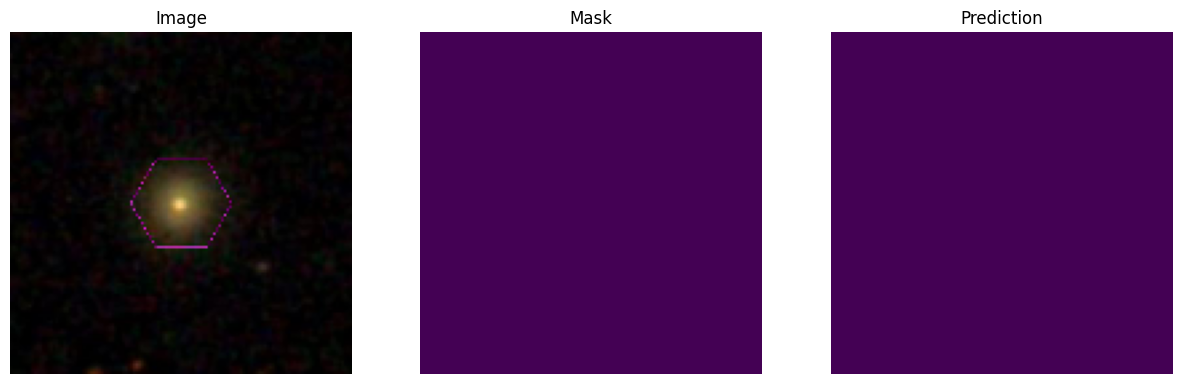

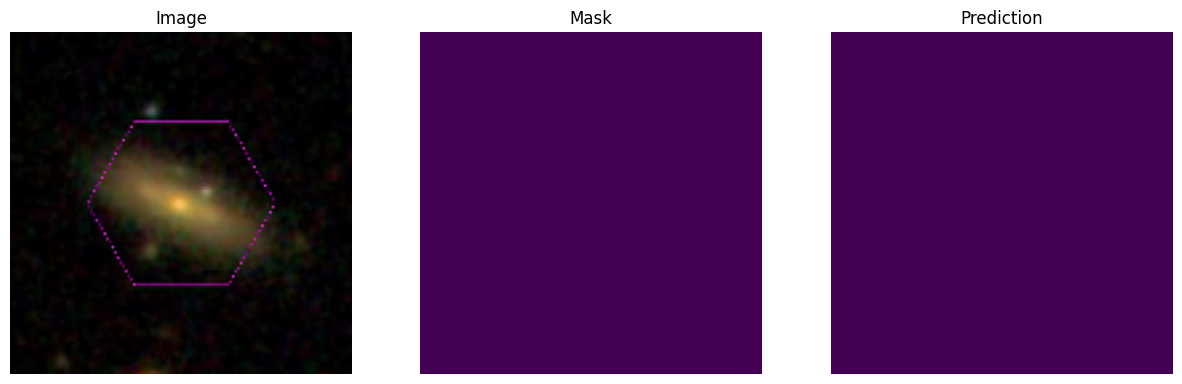

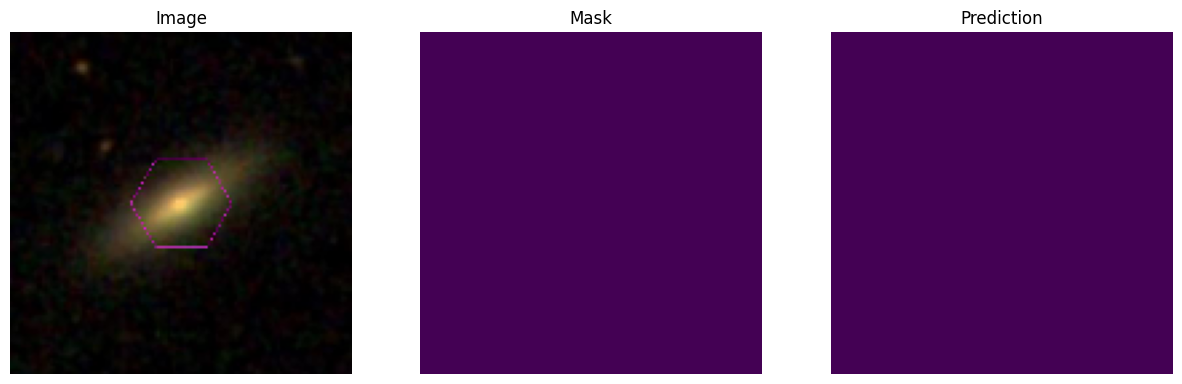

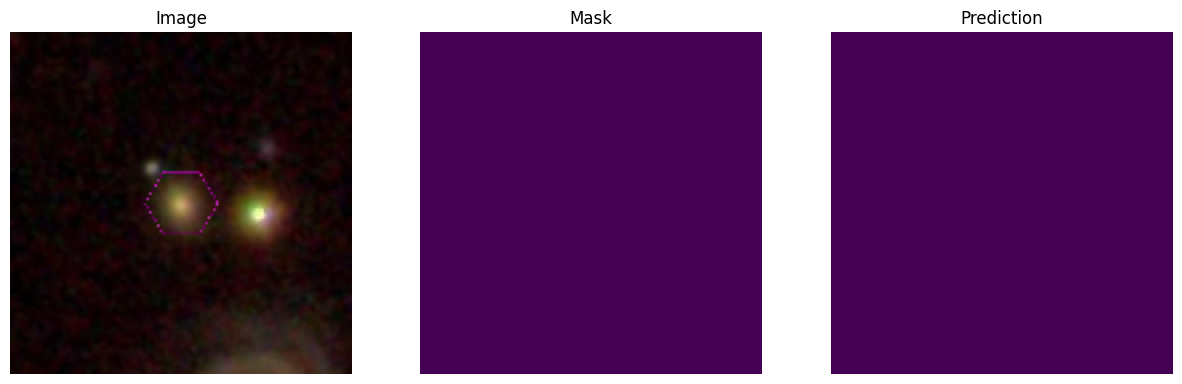

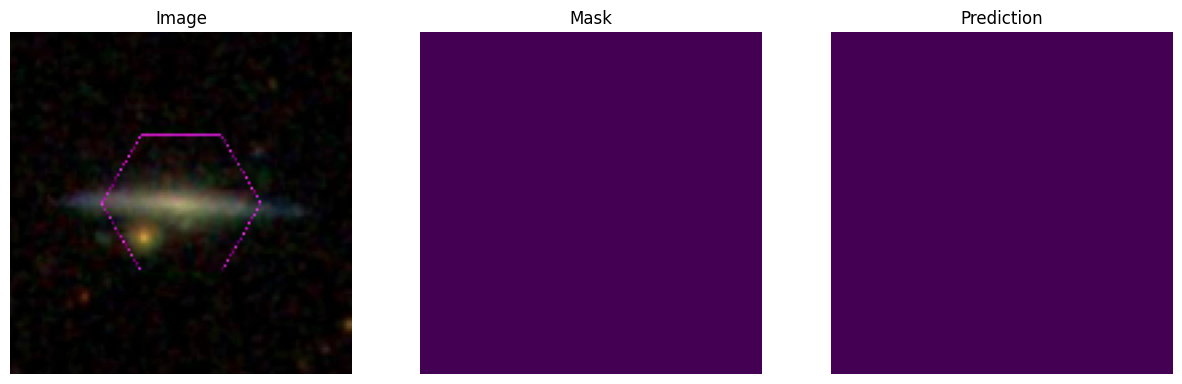

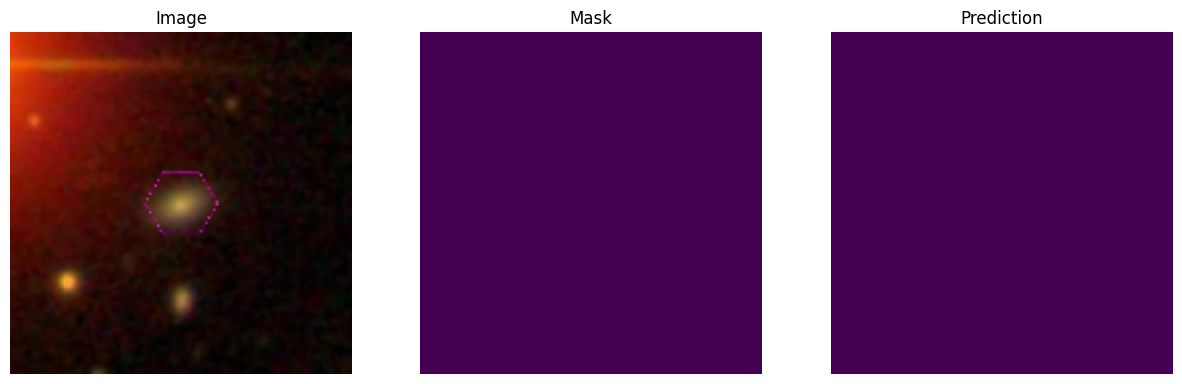

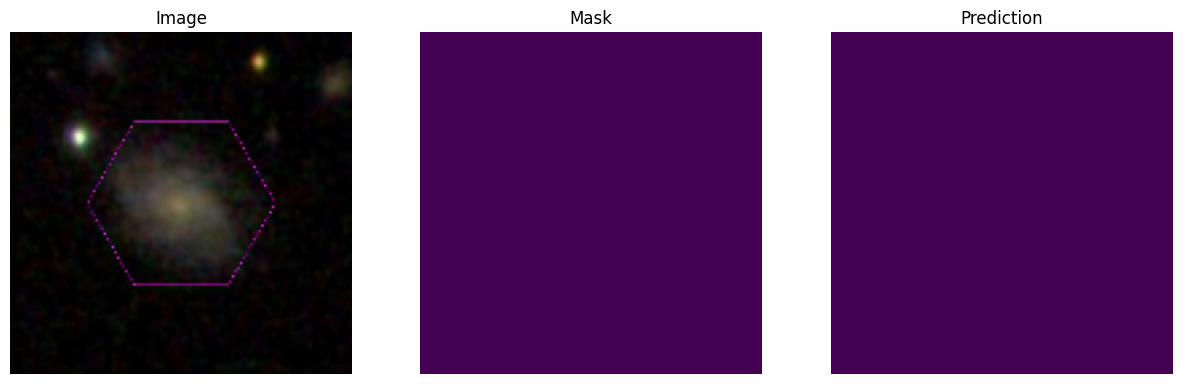

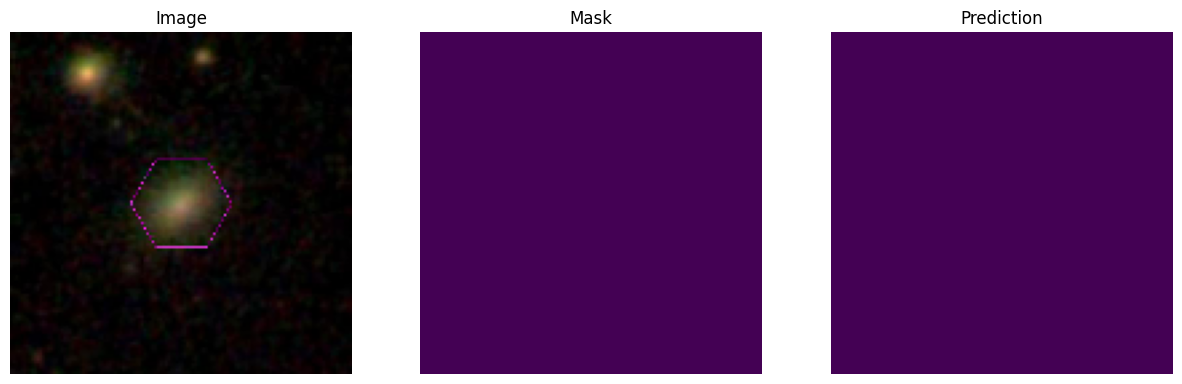

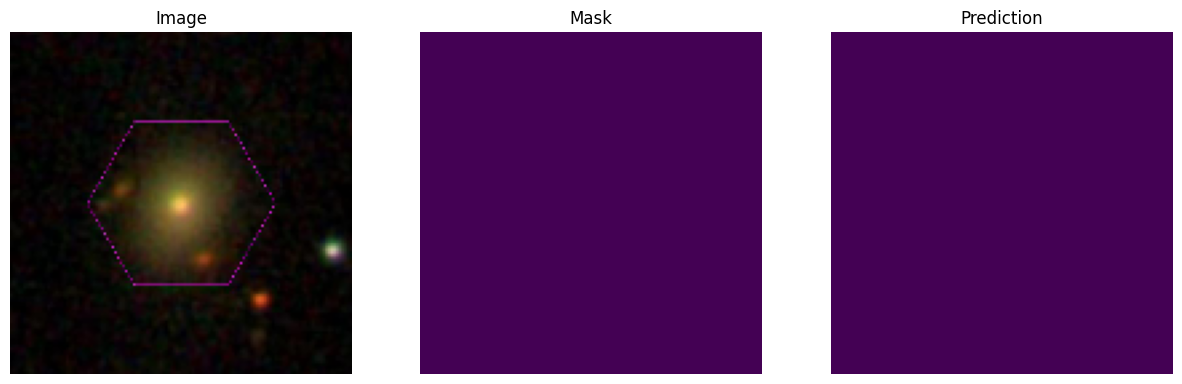

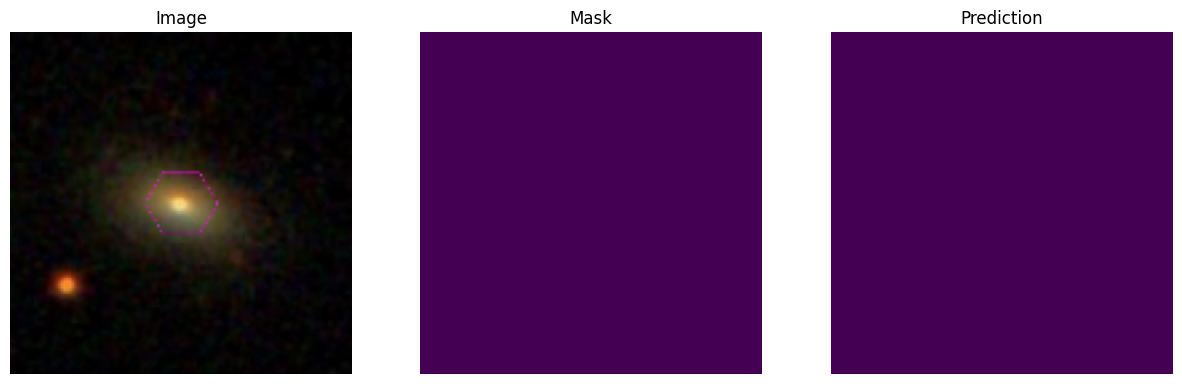

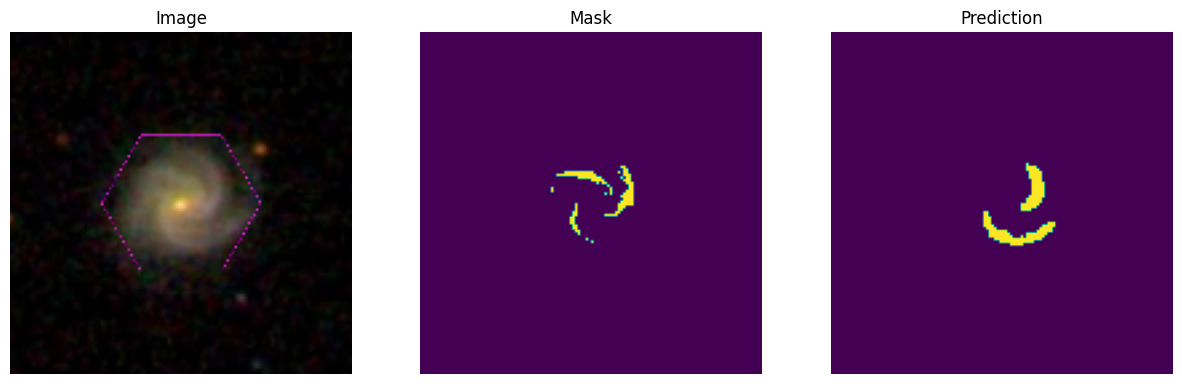

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[16109    70]
 [  141    64]] 	 0.31 	  	   0.48 	      0.99 		 0.23 



In [ ]:
show_predictions(test_batches.skip(random.randint(0, 15)).take(1), 25)